# Import Necessary Library

In [1]:
import time
from haversine_script import *
import numpy as np
import tensorflow as tf
import random
import pandas as p
import math
import matplotlib.pyplot as plt
import os
 


In [2]:

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import Callback, TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [3]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 } ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)
tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# Dataset Preprocessing Functions

In [4]:
def get_exponential_distance(x,minimum,a=60):
	positive_x= x-minimum
	numerator = np.exp(positive_x.div(a))
	denominator = np.exp(-minimum/a)
	exponential_x = numerator/denominator
	exponential_x = exponential_x * 1000  #facilitating calculations
	final_x = exponential_x
	return final_x

In [5]:
def get_powed_distance(x,minimum,b=1.1):
	positive_x= x-minimum
	numerator = positive_x.pow(b)
	denominator = (-minimum)**(b)
	powed_x = numerator/denominator
	final_x = powed_x
	return final_x

# Python Random Seeding for experiment reproducibility

In [6]:
os.environ['PYTHONHASHSEED'] = "42"
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [7]:
trial_name="MLP_withPCA=4"

In [8]:
components=4 # select the top 40 gateways 

In [9]:
#mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

# Loading Dataset

In [10]:
# reading the data
file = p.read_csv('lorawan_antwerp_2019_dataset.csv')
columns = file.columns
# x = file[columns[0:68]]
# y = file[columns[71:]]
x = file[columns[0:72]]
x = x.join(file[columns[73]])
y = file[columns[72:]]


Dataset Preprocessing

In [11]:
x = x.replace(-200,200)
minimum = x.min().min() - 1
x = x.replace(200,minimum)
print('minimum')
print(minimum)

minimum
-128.0


RSSI Data representation using Powed Function


In [12]:
final_x = get_powed_distance(x,minimum)

In [13]:
random_state = 42
x_train, x_test_val, y_train, y_test_val = train_test_split(final_x.values, y.values, test_size=0.3, random_state=random_state)
x_val, x_test, y_val, y_test = train_test_split(x_test_val, y_test_val, test_size=0.5, random_state=random_state)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(91300, 73)
(19564, 73)
(19565, 73)


In [14]:


scaler = preprocessing.MinMaxScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)


scaler_y = preprocessing.MinMaxScaler().fit(y_train)
y_train = scaler_y.transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)


PCA Application

In [15]:
pca = PCA(n_components =components) 
  
x_train = pca.fit_transform(x_train) 
x_val = pca.transform(x_val)
x_test = pca.transform(x_test)
explained_variance = pca.explained_variance_ratio_ 

In [16]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
n_of_features = x_train.shape[1]

(91300, 4)
(19564, 4)
(19565, 4)


# Network HyperParameters

In [17]:
dropout = 0.15
l2 = 0.00
lr = 0.0005
epochs = 10000
batch_size= 512
patience = 300

# Define the MLP Network

In [18]:
#with mirrored_strategy.scope():
model = Sequential()
model.add(Dense(units=1024, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=1024, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=1024, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=256, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=128, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=128, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(dropout))
model.add(Dense(units=2))
model.compile(loss='mean_absolute_error',optimizer=Adam(lr=lr))

cb =[EarlyStopping(monitor='val_loss', patience=patience, verbose =1, restore_best_weights=True)]
history = model.fit(x_train, y_train,validation_data=(x_val, y_val),epochs=epochs, batch_size=batch_size, verbose=1, callbacks= cb)


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/t

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_distributed_function_3436 in device /job:localhost/replica:0/task:0/device:GPU:0
90112/91300 [============================>.] - ETA: 0s - loss: 0.1490Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_4015 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
91300/91300 [==============================] - 21s 227us/sample - loss: 0.1481

91300/91300 [==============================] - 5s 50us/sample - loss: 0.0343 - val_loss: 0.0336
Epoch 30/10000
91300/91300 [==============================] - 5s 51us/sample - loss: 0.0341 - val_loss: 0.0304
Epoch 31/10000
91300/91300 [==============================] - 5s 49us/sample - loss: 0.0332 - val_loss: 0.0293
Epoch 32/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0338 - val_loss: 0.0311
Epoch 33/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0334 - val_loss: 0.0299
Epoch 34/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0330 - val_loss: 0.0292
Epoch 35/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0334 - val_loss: 0.0294
Epoch 36/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0331 - val_loss: 0.0285
Epoch 37/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0322 - val_loss: 0.0293
Epoch 38/10000
9

91300/91300 [==============================] - 4s 48us/sample - loss: 0.0296 - val_loss: 0.0302
Epoch 61/10000
91300/91300 [==============================] - 5s 49us/sample - loss: 0.0294 - val_loss: 0.0288
Epoch 62/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0295 - val_loss: 0.0277
Epoch 63/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0294 - val_loss: 0.0282
Epoch 64/10000
91300/91300 [==============================] - 5s 51us/sample - loss: 0.0296 - val_loss: 0.0287
Epoch 65/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0294 - val_loss: 0.0278
Epoch 66/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0292 - val_loss: 0.0298
Epoch 67/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0293 - val_loss: 0.0262
Epoch 68/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0290 - val_loss: 0.0270
Epoch 69/10000
9

Epoch 92/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0277 - val_loss: 0.0254
Epoch 93/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0275 - val_loss: 0.0261
Epoch 94/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0276 - val_loss: 0.0255
Epoch 95/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0272 - val_loss: 0.0257
Epoch 96/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0273 - val_loss: 0.0272
Epoch 97/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0273 - val_loss: 0.0257
Epoch 98/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0274 - val_loss: 0.0253
Epoch 99/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0274 - val_loss: 0.0264
Epoch 100/10000
91300/91300 [==============================] - 5s 51us/sample - loss: 0.0273 - val_loss: 0.0257


91300/91300 [==============================] - 4s 46us/sample - loss: 0.0264 - val_loss: 0.0249
Epoch 124/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0266 - val_loss: 0.0247
Epoch 125/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0263 - val_loss: 0.0241
Epoch 126/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0262 - val_loss: 0.0243
Epoch 127/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0264 - val_loss: 0.0267
Epoch 128/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0263 - val_loss: 0.0247
Epoch 129/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0262 - val_loss: 0.0240
Epoch 130/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0262 - val_loss: 0.0245
Epoch 131/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0265 - val_loss: 0.0250
Epoch 13

91300/91300 [==============================] - 4s 47us/sample - loss: 0.0258 - val_loss: 0.0239
Epoch 155/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0255 - val_loss: 0.0238
Epoch 156/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0255 - val_loss: 0.0239
Epoch 157/10000
91300/91300 [==============================] - 6s 61us/sample - loss: 0.0255 - val_loss: 0.0256
Epoch 158/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0256 - val_loss: 0.0241
Epoch 159/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0254 - val_loss: 0.0241
Epoch 160/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0253 - val_loss: 0.0243
Epoch 161/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0254 - val_loss: 0.0247
Epoch 162/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0254 - val_loss: 0.0241
Epoch 16

91300/91300 [==============================] - 4s 48us/sample - loss: 0.0250 - val_loss: 0.0230
Epoch 186/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0249 - val_loss: 0.0243
Epoch 187/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0249 - val_loss: 0.0245
Epoch 188/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0250 - val_loss: 0.0240
Epoch 189/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0249 - val_loss: 0.0237
Epoch 190/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0249 - val_loss: 0.0238
Epoch 191/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0248 - val_loss: 0.0235
Epoch 192/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0248 - val_loss: 0.0231
Epoch 193/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0249 - val_loss: 0.0236
Epoch 19

Epoch 217/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0244 - val_loss: 0.0236
Epoch 218/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0246 - val_loss: 0.0235
Epoch 219/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0244 - val_loss: 0.0234
Epoch 220/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0243 - val_loss: 0.0237
Epoch 221/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0243 - val_loss: 0.0224
Epoch 222/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0243 - val_loss: 0.0233
Epoch 223/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0243 - val_loss: 0.0234
Epoch 224/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0244 - val_loss: 0.0226
Epoch 225/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0244 - val_loss:

91300/91300 [==============================] - 4s 47us/sample - loss: 0.0241 - val_loss: 0.0231
Epoch 249/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0240 - val_loss: 0.0229
Epoch 250/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0241 - val_loss: 0.0233
Epoch 251/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0241 - val_loss: 0.0234
Epoch 252/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0241 - val_loss: 0.0226
Epoch 253/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0241 - val_loss: 0.0221
Epoch 254/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0239 - val_loss: 0.0232
Epoch 255/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0238 - val_loss: 0.0226
Epoch 256/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0240 - val_loss: 0.0230
Epoch 25

91300/91300 [==============================] - 4s 46us/sample - loss: 0.0236 - val_loss: 0.0226
Epoch 280/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0236 - val_loss: 0.0223
Epoch 281/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0236 - val_loss: 0.0228
Epoch 282/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0237 - val_loss: 0.0224
Epoch 283/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0236 - val_loss: 0.0225
Epoch 284/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0236 - val_loss: 0.0220
Epoch 285/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0236 - val_loss: 0.0230
Epoch 286/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0234 - val_loss: 0.0228
Epoch 287/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0236 - val_loss: 0.0224
Epoch 28

91300/91300 [==============================] - 4s 48us/sample - loss: 0.0234 - val_loss: 0.0226
Epoch 311/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0233 - val_loss: 0.0223
Epoch 312/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0235 - val_loss: 0.0218
Epoch 313/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0233 - val_loss: 0.0218
Epoch 314/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0234 - val_loss: 0.0223
Epoch 315/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0232 - val_loss: 0.0228
Epoch 316/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0232 - val_loss: 0.0220
Epoch 317/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0231 - val_loss: 0.0226
Epoch 318/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0234 - val_loss: 0.0225
Epoch 31

Epoch 342/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0231 - val_loss: 0.0219
Epoch 343/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0229 - val_loss: 0.0223
Epoch 344/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0230 - val_loss: 0.0215
Epoch 345/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0229 - val_loss: 0.0221
Epoch 346/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0231 - val_loss: 0.0218
Epoch 347/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0230 - val_loss: 0.0219
Epoch 348/10000
91300/91300 [==============================] - 6s 63us/sample - loss: 0.0229 - val_loss: 0.0222
Epoch 349/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0228 - val_loss: 0.0221
Epoch 350/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0230 - val_loss:

91300/91300 [==============================] - 4s 48us/sample - loss: 0.0228 - val_loss: 0.0216
Epoch 374/10000
91300/91300 [==============================] - 5s 49us/sample - loss: 0.0227 - val_loss: 0.0217
Epoch 375/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0227 - val_loss: 0.0215
Epoch 376/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0228 - val_loss: 0.0215
Epoch 377/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0228 - val_loss: 0.0215
Epoch 378/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0227 - val_loss: 0.0225
Epoch 379/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0229 - val_loss: 0.0222
Epoch 380/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0228 - val_loss: 0.0217
Epoch 381/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0227 - val_loss: 0.0217
Epoch 38

91300/91300 [==============================] - 4s 48us/sample - loss: 0.0225 - val_loss: 0.0223
Epoch 405/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0225 - val_loss: 0.0216
Epoch 406/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0226 - val_loss: 0.0220
Epoch 407/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0225 - val_loss: 0.0218
Epoch 408/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0224 - val_loss: 0.0215
Epoch 409/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0226 - val_loss: 0.0218
Epoch 410/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0225 - val_loss: 0.0217
Epoch 411/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0226 - val_loss: 0.0216
Epoch 412/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0226 - val_loss: 0.0220
Epoch 41

Epoch 436/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0222 - val_loss: 0.0218
Epoch 437/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0224 - val_loss: 0.0220
Epoch 438/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0223 - val_loss: 0.0221
Epoch 439/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0223 - val_loss: 0.0216
Epoch 440/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0224 - val_loss: 0.0220
Epoch 441/10000
91300/91300 [==============================] - 3s 35us/sample - loss: 0.0223 - val_loss: 0.0216
Epoch 442/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0224 - val_loss: 0.0226
Epoch 443/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0224 - val_loss: 0.0215
Epoch 444/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0222 - val_loss:

91300/91300 [==============================] - 4s 41us/sample - loss: 0.0222 - val_loss: 0.0214
Epoch 468/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0222 - val_loss: 0.0214
Epoch 469/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0221 - val_loss: 0.0216
Epoch 470/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0222 - val_loss: 0.0212
Epoch 471/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0222 - val_loss: 0.0215
Epoch 472/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0221 - val_loss: 0.0211
Epoch 473/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0220 - val_loss: 0.0216
Epoch 474/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0221 - val_loss: 0.0211
Epoch 475/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0220 - val_loss: 0.0218
Epoch 47

91300/91300 [==============================] - 4s 41us/sample - loss: 0.0219 - val_loss: 0.0215
Epoch 499/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0220 - val_loss: 0.0214
Epoch 500/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0219 - val_loss: 0.0215
Epoch 501/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0220 - val_loss: 0.0215
Epoch 502/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0220 - val_loss: 0.0212
Epoch 503/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0219 - val_loss: 0.0214
Epoch 504/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0220 - val_loss: 0.0218
Epoch 505/10000
91300/91300 [==============================] - 3s 35us/sample - loss: 0.0219 - val_loss: 0.0210
Epoch 506/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0218 - val_loss: 0.0215
Epoch 50

Epoch 530/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0218 - val_loss: 0.0213
Epoch 531/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0219 - val_loss: 0.0212
Epoch 532/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0217 - val_loss: 0.0211
Epoch 533/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0218 - val_loss: 0.0214
Epoch 534/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0219 - val_loss: 0.0216
Epoch 535/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0219 - val_loss: 0.0211
Epoch 536/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0219 - val_loss: 0.0215
Epoch 537/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0217 - val_loss: 0.0211
Epoch 538/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0218 - val_loss:

91300/91300 [==============================] - 4s 41us/sample - loss: 0.0216 - val_loss: 0.0213
Epoch 562/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0216 - val_loss: 0.0209
Epoch 563/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0216 - val_loss: 0.0211
Epoch 564/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0217 - val_loss: 0.0209
Epoch 565/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0217 - val_loss: 0.0216
Epoch 566/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0216 - val_loss: 0.0213
Epoch 567/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0217 - val_loss: 0.0220
Epoch 568/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0217 - val_loss: 0.0217
Epoch 569/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0217 - val_loss: 0.0209
Epoch 57

91300/91300 [==============================] - 4s 45us/sample - loss: 0.0215 - val_loss: 0.0209
Epoch 593/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0216 - val_loss: 0.0212
Epoch 594/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0215 - val_loss: 0.0207
Epoch 595/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0214 - val_loss: 0.0211
Epoch 596/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0216 - val_loss: 0.0208
Epoch 597/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0214 - val_loss: 0.0208
Epoch 598/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0214 - val_loss: 0.0208
Epoch 599/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0215 - val_loss: 0.0217
Epoch 600/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0215 - val_loss: 0.0215
Epoch 60

Epoch 624/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0214 - val_loss: 0.0206
Epoch 625/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0212 - val_loss: 0.0205
Epoch 626/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0214 - val_loss: 0.0207
Epoch 627/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0214 - val_loss: 0.0209
Epoch 628/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0214 - val_loss: 0.0210
Epoch 629/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0214 - val_loss: 0.0210
Epoch 630/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0214 - val_loss: 0.0208
Epoch 631/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0214 - val_loss: 0.0209
Epoch 632/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0214 - val_loss:

91300/91300 [==============================] - 4s 42us/sample - loss: 0.0213 - val_loss: 0.0208
Epoch 656/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0213 - val_loss: 0.0217
Epoch 657/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0213 - val_loss: 0.0209
Epoch 658/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0213 - val_loss: 0.0208
Epoch 659/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0213 - val_loss: 0.0208
Epoch 660/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0213 - val_loss: 0.0210
Epoch 661/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0212 - val_loss: 0.0212
Epoch 662/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0213 - val_loss: 0.0209
Epoch 663/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0212 - val_loss: 0.0209
Epoch 66

91300/91300 [==============================] - 4s 43us/sample - loss: 0.0212 - val_loss: 0.0209
Epoch 687/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0212 - val_loss: 0.0209
Epoch 688/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0211 - val_loss: 0.0204
Epoch 689/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0212 - val_loss: 0.0207
Epoch 690/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0212 - val_loss: 0.0207
Epoch 691/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0211 - val_loss: 0.0210
Epoch 692/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0211 - val_loss: 0.0214
Epoch 693/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0212 - val_loss: 0.0210
Epoch 694/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0211 - val_loss: 0.0207
Epoch 69

Epoch 718/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0211 - val_loss: 0.0207
Epoch 719/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0210 - val_loss: 0.0204
Epoch 720/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0210 - val_loss: 0.0211
Epoch 721/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0212 - val_loss: 0.0207
Epoch 722/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0210 - val_loss: 0.0209
Epoch 723/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0209 - val_loss: 0.0205
Epoch 724/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0210 - val_loss: 0.0207
Epoch 725/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0210 - val_loss: 0.0211
Epoch 726/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0211 - val_loss:

91300/91300 [==============================] - 4s 45us/sample - loss: 0.0210 - val_loss: 0.0212
Epoch 750/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0209 - val_loss: 0.0207
Epoch 751/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0208 - val_loss: 0.0205
Epoch 752/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0209 - val_loss: 0.0205
Epoch 753/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0209 - val_loss: 0.0210
Epoch 754/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0209 - val_loss: 0.0208
Epoch 755/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0210 - val_loss: 0.0209
Epoch 756/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0210 - val_loss: 0.0205
Epoch 757/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0209 - val_loss: 0.0212
Epoch 75

91300/91300 [==============================] - 4s 45us/sample - loss: 0.0208 - val_loss: 0.0210
Epoch 781/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0209 - val_loss: 0.0204
Epoch 782/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0209 - val_loss: 0.0205
Epoch 783/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0209 - val_loss: 0.0203
Epoch 784/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0209 - val_loss: 0.0207
Epoch 785/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0208 - val_loss: 0.0206
Epoch 786/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0209 - val_loss: 0.0209
Epoch 787/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0208 - val_loss: 0.0209
Epoch 788/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0208 - val_loss: 0.0212
Epoch 78

91300/91300 [==============================] - 4s 45us/sample - loss: 0.0209 - val_loss: 0.0209
Epoch 812/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0207 - val_loss: 0.0203
Epoch 813/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0207 - val_loss: 0.0205
Epoch 814/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0207 - val_loss: 0.0204
Epoch 815/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0208 - val_loss: 0.0204
Epoch 816/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0208 - val_loss: 0.0203
Epoch 817/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0207 - val_loss: 0.0208
Epoch 818/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0208 - val_loss: 0.0205
Epoch 819/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0208 - val_loss: 0.0208
Epoch 82

91300/91300 [==============================] - 4s 44us/sample - loss: 0.0207 - val_loss: 0.0205
Epoch 843/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0207 - val_loss: 0.0203
Epoch 844/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0206 - val_loss: 0.0210
Epoch 845/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0207 - val_loss: 0.0203
Epoch 846/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0207 - val_loss: 0.0205
Epoch 847/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0207 - val_loss: 0.0203
Epoch 848/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0207 - val_loss: 0.0205
Epoch 849/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0205 - val_loss: 0.0202
Epoch 850/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0207 - val_loss: 0.0209
Epoch 85

Epoch 874/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0206 - val_loss: 0.0206
Epoch 875/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0205 - val_loss: 0.0203
Epoch 876/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0206 - val_loss: 0.0205
Epoch 877/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0206 - val_loss: 0.0207
Epoch 878/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0206 - val_loss: 0.0204
Epoch 879/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0205 - val_loss: 0.0205
Epoch 880/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0207 - val_loss: 0.0208
Epoch 881/10000
91300/91300 [==============================] - 3s 38us/sample - loss: 0.0206 - val_loss: 0.0205
Epoch 882/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0205 - val_loss:

91300/91300 [==============================] - 4s 43us/sample - loss: 0.0206 - val_loss: 0.0205
Epoch 906/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0205 - val_loss: 0.0206
Epoch 907/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0206 - val_loss: 0.0206
Epoch 908/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0205 - val_loss: 0.0203
Epoch 909/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0205 - val_loss: 0.0204
Epoch 910/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0206 - val_loss: 0.0206
Epoch 911/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0206 - val_loss: 0.0206
Epoch 912/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0205 - val_loss: 0.0207
Epoch 913/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0206 - val_loss: 0.0205
Epoch 91

91300/91300 [==============================] - 4s 44us/sample - loss: 0.0204 - val_loss: 0.0204
Epoch 937/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0204 - val_loss: 0.0209
Epoch 938/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0203 - val_loss: 0.0203
Epoch 939/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0204 - val_loss: 0.0203
Epoch 940/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0205 - val_loss: 0.0202
Epoch 941/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0204 - val_loss: 0.0203
Epoch 942/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0204 - val_loss: 0.0207
Epoch 943/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0206 - val_loss: 0.0205
Epoch 944/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0204 - val_loss: 0.0204
Epoch 94

Epoch 968/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0204 - val_loss: 0.0202
Epoch 969/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0203 - val_loss: 0.0206
Epoch 970/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0203 - val_loss: 0.0206
Epoch 971/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0203 - val_loss: 0.0206
Epoch 972/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0204 - val_loss: 0.0203
Epoch 973/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0204 - val_loss: 0.0209
Epoch 974/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0205 - val_loss: 0.0204
Epoch 975/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0204 - val_loss: 0.0207
Epoch 976/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0203 - val_loss:

91300/91300 [==============================] - 4s 43us/sample - loss: 0.0203 - val_loss: 0.0203
Epoch 1000/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0203 - val_loss: 0.0203
Epoch 1001/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0203 - val_loss: 0.0206
Epoch 1002/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0204 - val_loss: 0.0201
Epoch 1003/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0203 - val_loss: 0.0205
Epoch 1004/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0203 - val_loss: 0.0201
Epoch 1005/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0203 - val_loss: 0.0203
Epoch 1006/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0204 - val_loss: 0.0207
Epoch 1007/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0203 - val_loss: 0.0206


91300/91300 [==============================] - 4s 44us/sample - loss: 0.0205 - val_loss: 0.0211
Epoch 1031/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0203 - val_loss: 0.0205
Epoch 1032/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0202 - val_loss: 0.0201
Epoch 1033/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0202 - val_loss: 0.0204
Epoch 1034/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0202 - val_loss: 0.0201
Epoch 1035/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0202 - val_loss: 0.0201
Epoch 1036/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0203 - val_loss: 0.0201
Epoch 1037/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0202 - val_loss: 0.0206
Epoch 1038/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0202 - val_loss: 0.0200


91300/91300 [==============================] - 4s 45us/sample - loss: 0.0201 - val_loss: 0.0202
Epoch 1062/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0202 - val_loss: 0.0205
Epoch 1063/10000
91300/91300 [==============================] - 5s 58us/sample - loss: 0.0202 - val_loss: 0.0202
Epoch 1064/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0201 - val_loss: 0.0202
Epoch 1065/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0201 - val_loss: 0.0201
Epoch 1066/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0203 - val_loss: 0.0203
Epoch 1067/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0202 - val_loss: 0.0204
Epoch 1068/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0201 - val_loss: 0.0202
Epoch 1069/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0203 - val_loss: 0.0201


91300/91300 [==============================] - 4s 42us/sample - loss: 0.0201 - val_loss: 0.0202
Epoch 1093/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0201 - val_loss: 0.0201
Epoch 1094/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0201 - val_loss: 0.0206
Epoch 1095/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0201 - val_loss: 0.0206
Epoch 1096/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0201 - val_loss: 0.0204
Epoch 1097/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0201 - val_loss: 0.0203
Epoch 1098/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0200 - val_loss: 0.0204
Epoch 1099/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0201 - val_loss: 0.0206
Epoch 1100/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0201 - val_loss: 0.0197


91300/91300 [==============================] - 4s 45us/sample - loss: 0.0201 - val_loss: 0.0202
Epoch 1124/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0201 - val_loss: 0.0203
Epoch 1125/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0199 - val_loss: 0.0206
Epoch 1126/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0200 - val_loss: 0.0207
Epoch 1127/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0200 - val_loss: 0.0204
Epoch 1128/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0200 - val_loss: 0.0204
Epoch 1129/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0202 - val_loss: 0.0203
Epoch 1130/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0200 - val_loss: 0.0199
Epoch 1131/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0200 - val_loss: 0.0203


91300/91300 [==============================] - 4s 41us/sample - loss: 0.0200 - val_loss: 0.0203
Epoch 1155/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0201 - val_loss: 0.0206
Epoch 1156/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0200 - val_loss: 0.0200
Epoch 1157/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0200 - val_loss: 0.0204
Epoch 1158/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0200 - val_loss: 0.0204
Epoch 1159/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0200 - val_loss: 0.0206
Epoch 1160/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0200 - val_loss: 0.0201
Epoch 1161/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0200 - val_loss: 0.0203
Epoch 1162/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0200 - val_loss: 0.0203


91300/91300 [==============================] - 4s 43us/sample - loss: 0.0200 - val_loss: 0.0203
Epoch 1186/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0200 - val_loss: 0.0199
Epoch 1187/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0200 - val_loss: 0.0204
Epoch 1188/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0199 - val_loss: 0.0204
Epoch 1189/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0200 - val_loss: 0.0202
Epoch 1190/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0199 - val_loss: 0.0206
Epoch 1191/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0200 - val_loss: 0.0201
Epoch 1192/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0200 - val_loss: 0.0202
Epoch 1193/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0198 - val_loss: 0.0202


91300/91300 [==============================] - 4s 41us/sample - loss: 0.0199 - val_loss: 0.0205
Epoch 1217/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0200 - val_loss: 0.0203
Epoch 1218/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0199 - val_loss: 0.0202
Epoch 1219/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0198 - val_loss: 0.0204
Epoch 1220/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0199 - val_loss: 0.0200
Epoch 1221/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0200 - val_loss: 0.0203
Epoch 1222/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0198 - val_loss: 0.0201
Epoch 1223/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0200 - val_loss: 0.0204
Epoch 1224/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0200 - val_loss: 0.0202


91300/91300 [==============================] - 4s 40us/sample - loss: 0.0198 - val_loss: 0.0201
Epoch 1248/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0199 - val_loss: 0.0200
Epoch 1249/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0199 - val_loss: 0.0198
Epoch 1250/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0199 - val_loss: 0.0204
Epoch 1251/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0199 - val_loss: 0.0204
Epoch 1252/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0199 - val_loss: 0.0201
Epoch 1253/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0199 - val_loss: 0.0204
Epoch 1254/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0198 - val_loss: 0.0206
Epoch 1255/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0198 - val_loss: 0.0199


91300/91300 [==============================] - 4s 42us/sample - loss: 0.0198 - val_loss: 0.0202
Epoch 1279/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0198 - val_loss: 0.0202
Epoch 1280/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0199 - val_loss: 0.0203
Epoch 1281/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0197 - val_loss: 0.0204
Epoch 1282/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0198 - val_loss: 0.0201
Epoch 1283/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0198 - val_loss: 0.0201
Epoch 1284/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0198 - val_loss: 0.0204
Epoch 1285/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0197 - val_loss: 0.0206
Epoch 1286/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0199 - val_loss: 0.0201


91300/91300 [==============================] - 4s 41us/sample - loss: 0.0197 - val_loss: 0.0201
Epoch 1310/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0197 - val_loss: 0.0204
Epoch 1311/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0198 - val_loss: 0.0202
Epoch 1312/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0197 - val_loss: 0.0204
Epoch 1313/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0198 - val_loss: 0.0207
Epoch 1314/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0198 - val_loss: 0.0201
Epoch 1315/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0199 - val_loss: 0.0204
Epoch 1316/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0198 - val_loss: 0.0201
Epoch 1317/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0196 - val_loss: 0.0200


91300/91300 [==============================] - 4s 46us/sample - loss: 0.0199 - val_loss: 0.0198
Epoch 1341/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0197 - val_loss: 0.0199
Epoch 1342/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0198 - val_loss: 0.0202
Epoch 1343/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0198 - val_loss: 0.0204
Epoch 1344/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0197 - val_loss: 0.0202
Epoch 1345/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0198 - val_loss: 0.0201
Epoch 1346/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0196 - val_loss: 0.0201
Epoch 1347/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0197 - val_loss: 0.0203
Epoch 1348/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0197 - val_loss: 0.0206


91300/91300 [==============================] - 4s 46us/sample - loss: 0.0196 - val_loss: 0.0203
Epoch 1372/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0197 - val_loss: 0.0202
Epoch 1373/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0197 - val_loss: 0.0203
Epoch 1374/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0197 - val_loss: 0.0204
Epoch 1375/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0196 - val_loss: 0.0201
Epoch 1376/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0197 - val_loss: 0.0199
Epoch 1377/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0196 - val_loss: 0.0199
Epoch 1378/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0196 - val_loss: 0.0201
Epoch 1379/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0197 - val_loss: 0.0204


91300/91300 [==============================] - 4s 47us/sample - loss: 0.0196 - val_loss: 0.0202
Epoch 1403/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0195 - val_loss: 0.0205
Epoch 1404/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0196 - val_loss: 0.0207
Epoch 1405/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0196 - val_loss: 0.0199
Epoch 1406/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0196 - val_loss: 0.0205
Epoch 1407/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0197 - val_loss: 0.0202
Epoch 1408/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0196 - val_loss: 0.0198
Epoch 1409/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0195 - val_loss: 0.0199
Epoch 1410/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0196 - val_loss: 0.0198


91300/91300 [==============================] - 4s 46us/sample - loss: 0.0195 - val_loss: 0.0199
Epoch 1434/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0196 - val_loss: 0.0202
Epoch 1435/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0195 - val_loss: 0.0200
Epoch 1436/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0195 - val_loss: 0.0199
Epoch 1437/10000
91300/91300 [==============================] - 5s 59us/sample - loss: 0.0196 - val_loss: 0.0201
Epoch 1438/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0196 - val_loss: 0.0203
Epoch 1439/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0196 - val_loss: 0.0200
Epoch 1440/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0196 - val_loss: 0.0203
Epoch 1441/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0197 - val_loss: 0.0208


91300/91300 [==============================] - 4s 46us/sample - loss: 0.0195 - val_loss: 0.0199
Epoch 1465/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0195 - val_loss: 0.0205
Epoch 1466/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0195 - val_loss: 0.0200
Epoch 1467/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0196 - val_loss: 0.0199
Epoch 1468/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0196 - val_loss: 0.0197
Epoch 1469/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0195 - val_loss: 0.0201
Epoch 1470/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0196 - val_loss: 0.0200
Epoch 1471/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0195 - val_loss: 0.0200
Epoch 1472/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0195 - val_loss: 0.0199


91300/91300 [==============================] - 4s 49us/sample - loss: 0.0194 - val_loss: 0.0202
Epoch 1496/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0194 - val_loss: 0.0202
Epoch 1497/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0196 - val_loss: 0.0203
Epoch 1498/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0196 - val_loss: 0.0201
Epoch 1499/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0196 - val_loss: 0.0202
Epoch 1500/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0195 - val_loss: 0.0198
Epoch 1501/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0195 - val_loss: 0.0204
Epoch 1502/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0195 - val_loss: 0.0203
Epoch 1503/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0195 - val_loss: 0.0198


91300/91300 [==============================] - 4s 47us/sample - loss: 0.0194 - val_loss: 0.0203
Epoch 1527/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0195 - val_loss: 0.0200
Epoch 1528/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0194 - val_loss: 0.0201
Epoch 1529/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0193 - val_loss: 0.0199
Epoch 1530/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0194 - val_loss: 0.0199
Epoch 1531/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0196 - val_loss: 0.0201
Epoch 1532/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0194 - val_loss: 0.0201
Epoch 1533/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0195 - val_loss: 0.0201
Epoch 1534/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0194 - val_loss: 0.0200


91300/91300 [==============================] - 4s 48us/sample - loss: 0.0194 - val_loss: 0.0200
Epoch 1558/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0194 - val_loss: 0.0203
Epoch 1559/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0194 - val_loss: 0.0200
Epoch 1560/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0195 - val_loss: 0.0200
Epoch 1561/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0194 - val_loss: 0.0200
Epoch 1562/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0194 - val_loss: 0.0201
Epoch 1563/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0194 - val_loss: 0.0205
Epoch 1564/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0194 - val_loss: 0.0203
Epoch 1565/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0194 - val_loss: 0.0204


91300/91300 [==============================] - 4s 48us/sample - loss: 0.0194 - val_loss: 0.0202
Epoch 1589/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0195 - val_loss: 0.0199
Epoch 1590/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0194 - val_loss: 0.0199
Epoch 1591/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0194 - val_loss: 0.0201
Epoch 1592/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0193 - val_loss: 0.0197
Epoch 1593/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0194 - val_loss: 0.0203
Epoch 1594/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0194 - val_loss: 0.0199
Epoch 1595/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0194 - val_loss: 0.0200
Epoch 1596/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0194 - val_loss: 0.0202


91300/91300 [==============================] - 4s 47us/sample - loss: 0.0194 - val_loss: 0.0199
Epoch 1620/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0193 - val_loss: 0.0201
Epoch 1621/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0192 - val_loss: 0.0203
Epoch 1622/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0193 - val_loss: 0.0201
Epoch 1623/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0193 - val_loss: 0.0199
Epoch 1624/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0193 - val_loss: 0.0198
Epoch 1625/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0193 - val_loss: 0.0205
Epoch 1626/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0194 - val_loss: 0.0201
Epoch 1627/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0194 - val_loss: 0.0197


91300/91300 [==============================] - 4s 49us/sample - loss: 0.0194 - val_loss: 0.0199
Epoch 1651/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0193 - val_loss: 0.0199
Epoch 1652/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0193 - val_loss: 0.0206
Epoch 1653/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0194 - val_loss: 0.0205
Epoch 1654/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0192 - val_loss: 0.0200
Epoch 1655/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0193 - val_loss: 0.0203
Epoch 1656/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0193 - val_loss: 0.0201
Epoch 1657/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0192 - val_loss: 0.0200
Epoch 1658/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0193 - val_loss: 0.0203


91300/91300 [==============================] - 4s 48us/sample - loss: 0.0193 - val_loss: 0.0200
Epoch 1682/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0192 - val_loss: 0.0204
Epoch 1683/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0192 - val_loss: 0.0200
Epoch 1684/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0193 - val_loss: 0.0199
Epoch 1685/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0193 - val_loss: 0.0199
Epoch 1686/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0194 - val_loss: 0.0200
Epoch 1687/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0193 - val_loss: 0.0200
Epoch 1688/10000
91300/91300 [==============================] - 5s 49us/sample - loss: 0.0192 - val_loss: 0.0201
Epoch 1689/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0192 - val_loss: 0.0196


91300/91300 [==============================] - 4s 45us/sample - loss: 0.0192 - val_loss: 0.0199
Epoch 1713/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0192 - val_loss: 0.0203
Epoch 1714/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0193 - val_loss: 0.0201
Epoch 1715/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0193 - val_loss: 0.0202
Epoch 1716/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0193 - val_loss: 0.0201
Epoch 1717/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0192 - val_loss: 0.0199
Epoch 1718/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0191 - val_loss: 0.0200
Epoch 1719/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0192 - val_loss: 0.0202
Epoch 1720/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0191 - val_loss: 0.0201


91300/91300 [==============================] - 4s 49us/sample - loss: 0.0192 - val_loss: 0.0200
Epoch 1744/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0194 - val_loss: 0.0199
Epoch 1745/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0192 - val_loss: 0.0201
Epoch 1746/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0192 - val_loss: 0.0202
Epoch 1747/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0191 - val_loss: 0.0209
Epoch 1748/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0193 - val_loss: 0.0199
Epoch 1749/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0192 - val_loss: 0.0198
Epoch 1750/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0192 - val_loss: 0.0196
Epoch 1751/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0192 - val_loss: 0.0199


91300/91300 [==============================] - 4s 46us/sample - loss: 0.0191 - val_loss: 0.0200
Epoch 1775/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0192 - val_loss: 0.0201
Epoch 1776/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0192 - val_loss: 0.0198
Epoch 1777/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0192 - val_loss: 0.0199
Epoch 1778/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0191 - val_loss: 0.0200
Epoch 1779/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0192 - val_loss: 0.0204
Epoch 1780/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0192 - val_loss: 0.0200
Epoch 1781/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0190 - val_loss: 0.0201
Epoch 1782/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0192 - val_loss: 0.0197


91300/91300 [==============================] - 5s 59us/sample - loss: 0.0192 - val_loss: 0.0201
Epoch 1806/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0191 - val_loss: 0.0204
Epoch 1807/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0192 - val_loss: 0.0200
Epoch 1808/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0192 - val_loss: 0.0202
Epoch 1809/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0192 - val_loss: 0.0197
Epoch 1810/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0192 - val_loss: 0.0202
Epoch 1811/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0192 - val_loss: 0.0200
Epoch 1812/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0191 - val_loss: 0.0211
Epoch 1813/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0192 - val_loss: 0.0201


91300/91300 [==============================] - 4s 47us/sample - loss: 0.0192 - val_loss: 0.0200
Epoch 1837/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0191 - val_loss: 0.0197
Epoch 1838/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0190 - val_loss: 0.0197
Epoch 1839/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0191 - val_loss: 0.0199
Epoch 1840/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0192 - val_loss: 0.0201
Epoch 1841/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0191 - val_loss: 0.0199
Epoch 1842/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0190 - val_loss: 0.0198
Epoch 1843/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0190 - val_loss: 0.0200
Epoch 1844/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0191 - val_loss: 0.0199


91300/91300 [==============================] - 4s 47us/sample - loss: 0.0190 - val_loss: 0.0203
Epoch 1868/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0191 - val_loss: 0.0200
Epoch 1869/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0191 - val_loss: 0.0200
Epoch 1870/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0192 - val_loss: 0.0201
Epoch 1871/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0191 - val_loss: 0.0200
Epoch 1872/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0190 - val_loss: 0.0197
Epoch 1873/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0191 - val_loss: 0.0199
Epoch 1874/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0189 - val_loss: 0.0197
Epoch 1875/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0191 - val_loss: 0.0199


91300/91300 [==============================] - 4s 47us/sample - loss: 0.0190 - val_loss: 0.0202
Epoch 1899/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0190 - val_loss: 0.0199
Epoch 1900/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0190 - val_loss: 0.0206
Epoch 1901/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0192 - val_loss: 0.0202
Epoch 1902/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0189 - val_loss: 0.0199
Epoch 1903/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0191 - val_loss: 0.0199
Epoch 1904/10000
91300/91300 [==============================] - 5s 51us/sample - loss: 0.0190 - val_loss: 0.0201
Epoch 1905/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0192 - val_loss: 0.0202
Epoch 1906/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0191 - val_loss: 0.0203


91300/91300 [==============================] - 4s 49us/sample - loss: 0.0191 - val_loss: 0.0201
Epoch 1930/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0190 - val_loss: 0.0200
Epoch 1931/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0190 - val_loss: 0.0196
Epoch 1932/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0190 - val_loss: 0.0199
Epoch 1933/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0190 - val_loss: 0.0199
Epoch 1934/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0191 - val_loss: 0.0198
Epoch 1935/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0190 - val_loss: 0.0200
Epoch 1936/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0191 - val_loss: 0.0198
Epoch 1937/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0190 - val_loss: 0.0200


91300/91300 [==============================] - 4s 48us/sample - loss: 0.0190 - val_loss: 0.0197
Epoch 1961/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0190 - val_loss: 0.0201
Epoch 1962/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0190 - val_loss: 0.0199
Epoch 1963/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0190 - val_loss: 0.0199
Epoch 1964/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0189 - val_loss: 0.0198
Epoch 1965/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0190 - val_loss: 0.0198
Epoch 1966/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0190 - val_loss: 0.0202
Epoch 1967/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0190 - val_loss: 0.0200
Epoch 1968/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0190 - val_loss: 0.0200


91300/91300 [==============================] - 4s 46us/sample - loss: 0.0189 - val_loss: 0.0196
Epoch 1992/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0190 - val_loss: 0.0197
Epoch 1993/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0190 - val_loss: 0.0199
Epoch 1994/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0189 - val_loss: 0.0197
Epoch 1995/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0190 - val_loss: 0.0196
Epoch 1996/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0189 - val_loss: 0.0198
Epoch 1997/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0190 - val_loss: 0.0198
Epoch 1998/10000
91300/91300 [==============================] - 6s 61us/sample - loss: 0.0190 - val_loss: 0.0199
Epoch 1999/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0190 - val_loss: 0.0199


91300/91300 [==============================] - 4s 48us/sample - loss: 0.0189 - val_loss: 0.0199
Epoch 2023/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0190 - val_loss: 0.0200
Epoch 2024/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0189 - val_loss: 0.0197
Epoch 2025/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0189 - val_loss: 0.0200
Epoch 2026/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0190 - val_loss: 0.0200
Epoch 2027/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0190 - val_loss: 0.0201
Epoch 2028/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0190 - val_loss: 0.0197
Epoch 2029/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0190 - val_loss: 0.0197
Epoch 2030/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0189 - val_loss: 0.0200


91300/91300 [==============================] - 4s 47us/sample - loss: 0.0189 - val_loss: 0.0199
Epoch 2054/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0190 - val_loss: 0.0197
Epoch 2055/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0188 - val_loss: 0.0198
Epoch 2056/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0190 - val_loss: 0.0198
Epoch 2057/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0190 - val_loss: 0.0195
Epoch 2058/10000
91300/91300 [==============================] - 6s 61us/sample - loss: 0.0189 - val_loss: 0.0196
Epoch 2059/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0189 - val_loss: 0.0198
Epoch 2060/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0189 - val_loss: 0.0201
Epoch 2061/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0189 - val_loss: 0.0200


91300/91300 [==============================] - 4s 46us/sample - loss: 0.0189 - val_loss: 0.0199
Epoch 2085/10000
91300/91300 [==============================] - 5s 53us/sample - loss: 0.0189 - val_loss: 0.0199
Epoch 2086/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0189 - val_loss: 0.0199
Epoch 2087/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0189 - val_loss: 0.0196
Epoch 2088/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0188 - val_loss: 0.0198
Epoch 2089/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0190 - val_loss: 0.0198
Epoch 2090/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0189 - val_loss: 0.0197
Epoch 2091/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0190 - val_loss: 0.0201
Epoch 2092/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0188 - val_loss: 0.0196


91300/91300 [==============================] - 4s 48us/sample - loss: 0.0189 - val_loss: 0.0199
Epoch 2116/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0188 - val_loss: 0.0199
Epoch 2117/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0188 - val_loss: 0.0200
Epoch 2118/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0190 - val_loss: 0.0198
Epoch 2119/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0189 - val_loss: 0.0198
Epoch 2120/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0189 - val_loss: 0.0196
Epoch 2121/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0189 - val_loss: 0.0197
Epoch 2122/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0188 - val_loss: 0.0198
Epoch 2123/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0189 - val_loss: 0.0200


91300/91300 [==============================] - 4s 47us/sample - loss: 0.0189 - val_loss: 0.0196
Epoch 2147/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0189 - val_loss: 0.0196
Epoch 2148/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0189 - val_loss: 0.0202
Epoch 2149/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0189 - val_loss: 0.0202
Epoch 2150/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0187 - val_loss: 0.0198
Epoch 2151/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0188 - val_loss: 0.0200
Epoch 2152/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0188 - val_loss: 0.0196
Epoch 2153/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0189 - val_loss: 0.0202
Epoch 2154/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0188 - val_loss: 0.0197


91300/91300 [==============================] - 4s 48us/sample - loss: 0.0187 - val_loss: 0.0200
Epoch 2178/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0188 - val_loss: 0.0198
Epoch 2179/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0188 - val_loss: 0.0197
Epoch 2180/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0187 - val_loss: 0.0196
Epoch 2181/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0188 - val_loss: 0.0202
Epoch 2182/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0188 - val_loss: 0.0198
Epoch 2183/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0188 - val_loss: 0.0200
Epoch 2184/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0188 - val_loss: 0.0204
Epoch 2185/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0189 - val_loss: 0.0197


91300/91300 [==============================] - 4s 48us/sample - loss: 0.0188 - val_loss: 0.0199
Epoch 2209/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0188 - val_loss: 0.0198
Epoch 2210/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0188 - val_loss: 0.0197
Epoch 2211/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0188 - val_loss: 0.0197
Epoch 2212/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0187 - val_loss: 0.0199
Epoch 2213/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0187 - val_loss: 0.0202
Epoch 2214/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0188 - val_loss: 0.0196
Epoch 2215/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0188 - val_loss: 0.0200
Epoch 2216/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0188 - val_loss: 0.0201


91300/91300 [==============================] - 4s 44us/sample - loss: 0.0187 - val_loss: 0.0198
Epoch 2240/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0188 - val_loss: 0.0197
Epoch 2241/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0188 - val_loss: 0.0201
Epoch 2242/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0188 - val_loss: 0.0199
Epoch 2243/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0188 - val_loss: 0.0199
Epoch 2244/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0188 - val_loss: 0.0203
Epoch 2245/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0187 - val_loss: 0.0200
Epoch 2246/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0188 - val_loss: 0.0198
Epoch 2247/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0187 - val_loss: 0.0195


91300/91300 [==============================] - 4s 47us/sample - loss: 0.0188 - val_loss: 0.0200
Epoch 2271/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0187 - val_loss: 0.0197
Epoch 2272/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0188 - val_loss: 0.0196
Epoch 2273/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0187 - val_loss: 0.0196
Epoch 2274/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0188 - val_loss: 0.0200
Epoch 2275/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0187 - val_loss: 0.0199
Epoch 2276/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0188 - val_loss: 0.0198
Epoch 2277/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0188 - val_loss: 0.0203
Epoch 2278/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0189 - val_loss: 0.0199


Epoch 2301/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0187 - val_loss: 0.0196
Epoch 2302/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0187 - val_loss: 0.0200
Epoch 2303/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0187 - val_loss: 0.0196
Epoch 2304/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0186 - val_loss: 0.0200
Epoch 2305/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0188 - val_loss: 0.0202
Epoch 2306/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0187 - val_loss: 0.0198
Epoch 2307/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0187 - val_loss: 0.0198
Epoch 2308/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0187 - val_loss: 0.0199
Epoch 2309/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0187 - 

91300/91300 [==============================] - 4s 47us/sample - loss: 0.0187 - val_loss: 0.0199
Epoch 2333/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0187 - val_loss: 0.0198
Epoch 2334/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0188 - val_loss: 0.0198
Epoch 2335/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0188 - val_loss: 0.0199
Epoch 2336/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0187 - val_loss: 0.0203
Epoch 2337/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0187 - val_loss: 0.0203
Epoch 2338/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0186 - val_loss: 0.0200
Epoch 2339/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0187 - val_loss: 0.0198
Epoch 2340/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0187 - val_loss: 0.0198


91300/91300 [==============================] - 4s 47us/sample - loss: 0.0186 - val_loss: 0.0197
Epoch 2364/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0187 - val_loss: 0.0197
Epoch 2365/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0186 - val_loss: 0.0198
Epoch 2366/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0187 - val_loss: 0.0201
Epoch 2367/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0187 - val_loss: 0.0197
Epoch 2368/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0186 - val_loss: 0.0199
Epoch 2369/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0187 - val_loss: 0.0201
Epoch 2370/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0186 - val_loss: 0.0202
Epoch 2371/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0186 - val_loss: 0.0200


91300/91300 [==============================] - 4s 49us/sample - loss: 0.0186 - val_loss: 0.0199
Epoch 2395/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0187 - val_loss: 0.0204
Epoch 2396/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0187 - val_loss: 0.0202
Epoch 2397/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0186 - val_loss: 0.0200
Epoch 2398/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0186 - val_loss: 0.0198
Epoch 2399/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0187 - val_loss: 0.0200
Epoch 2400/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0186 - val_loss: 0.0197
Epoch 2401/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0186 - val_loss: 0.0199
Epoch 2402/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0186 - val_loss: 0.0199


91300/91300 [==============================] - 4s 48us/sample - loss: 0.0186 - val_loss: 0.0198
Epoch 2426/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0186 - val_loss: 0.0197
Epoch 2427/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0186 - val_loss: 0.0197
Epoch 2428/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0185 - val_loss: 0.0196
Epoch 2429/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0186 - val_loss: 0.0199
Epoch 2430/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0187 - val_loss: 0.0197
Epoch 2431/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0187 - val_loss: 0.0198
Epoch 2432/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0187 - val_loss: 0.0197
Epoch 2433/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0187 - val_loss: 0.0201


91300/91300 [==============================] - 4s 48us/sample - loss: 0.0186 - val_loss: 0.0203
Epoch 2457/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0186 - val_loss: 0.0199
Epoch 2458/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0186 - val_loss: 0.0198
Epoch 2459/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0186 - val_loss: 0.0200
Epoch 2460/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0186 - val_loss: 0.0202
Epoch 2461/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0186 - val_loss: 0.0196
Epoch 2462/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0186 - val_loss: 0.0196
Epoch 2463/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0186 - val_loss: 0.0197
Epoch 2464/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0186 - val_loss: 0.0197


91300/91300 [==============================] - 4s 47us/sample - loss: 0.0186 - val_loss: 0.0200
Epoch 2488/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0186 - val_loss: 0.0197
Epoch 2489/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0186 - val_loss: 0.0197
Epoch 2490/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0186 - val_loss: 0.0197
Epoch 2491/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0186 - val_loss: 0.0199
Epoch 2492/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0186 - val_loss: 0.0197
Epoch 2493/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0186 - val_loss: 0.0198
Epoch 2494/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0187 - val_loss: 0.0196
Epoch 2495/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0186 - val_loss: 0.0200


91300/91300 [==============================] - 4s 46us/sample - loss: 0.0185 - val_loss: 0.0200
Epoch 2519/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0185 - val_loss: 0.0198
Epoch 2520/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0185 - val_loss: 0.0199
Epoch 2521/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0186 - val_loss: 0.0201
Epoch 2522/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0186 - val_loss: 0.0197
Epoch 2523/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0185 - val_loss: 0.0202
Epoch 2524/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0185 - val_loss: 0.0198
Epoch 2525/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0185 - val_loss: 0.0198
Epoch 2526/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0185 - val_loss: 0.0197


91300/91300 [==============================] - 4s 48us/sample - loss: 0.0185 - val_loss: 0.0199
Epoch 2550/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0185 - val_loss: 0.0194
Epoch 2551/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0185 - val_loss: 0.0196
Epoch 2552/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0186 - val_loss: 0.0199
Epoch 2553/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0186 - val_loss: 0.0200
Epoch 2554/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0186 - val_loss: 0.0197
Epoch 2555/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0186 - val_loss: 0.0197
Epoch 2556/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0185 - val_loss: 0.0199
Epoch 2557/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0186 - val_loss: 0.0198


91300/91300 [==============================] - 4s 46us/sample - loss: 0.0185 - val_loss: 0.0198
Epoch 2581/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0185 - val_loss: 0.0197
Epoch 2582/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0185 - val_loss: 0.0198
Epoch 2583/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0184 - val_loss: 0.0200
Epoch 2584/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0185 - val_loss: 0.0197
Epoch 2585/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0184 - val_loss: 0.0201
Epoch 2586/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0185 - val_loss: 0.0197
Epoch 2587/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0186 - val_loss: 0.0197
Epoch 2588/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0185 - val_loss: 0.0202


91300/91300 [==============================] - 4s 47us/sample - loss: 0.0186 - val_loss: 0.0200
Epoch 2612/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0186 - val_loss: 0.0197
Epoch 2613/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0186 - val_loss: 0.0200
Epoch 2614/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0185 - val_loss: 0.0198
Epoch 2615/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0184 - val_loss: 0.0199
Epoch 2616/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0185 - val_loss: 0.0199
Epoch 2617/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0185 - val_loss: 0.0199
Epoch 2618/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0184 - val_loss: 0.0200
Epoch 2619/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0184 - val_loss: 0.0197


91300/91300 [==============================] - 4s 47us/sample - loss: 0.0184 - val_loss: 0.0200
Epoch 2643/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0185 - val_loss: 0.0197
Epoch 2644/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0185 - val_loss: 0.0198
Epoch 2645/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0185 - val_loss: 0.0196
Epoch 2646/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0185 - val_loss: 0.0199
Epoch 2647/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0185 - val_loss: 0.0199
Epoch 2648/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0185 - val_loss: 0.0196
Epoch 2649/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0185 - val_loss: 0.0198
Epoch 2650/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0185 - val_loss: 0.0197


91300/91300 [==============================] - 4s 45us/sample - loss: 0.0185 - val_loss: 0.0201
Epoch 2674/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0184 - val_loss: 0.0202
Epoch 2675/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0184 - val_loss: 0.0198
Epoch 2676/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0184 - val_loss: 0.0202
Epoch 2677/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0184 - val_loss: 0.0199
Epoch 2678/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0184 - val_loss: 0.0197
Epoch 2679/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0184 - val_loss: 0.0195
Epoch 2680/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0185 - val_loss: 0.0195
Epoch 2681/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0185 - val_loss: 0.0196


91300/91300 [==============================] - 4s 44us/sample - loss: 0.0185 - val_loss: 0.0199
Epoch 2705/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0185 - val_loss: 0.0200
Epoch 2706/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0183 - val_loss: 0.0203
Epoch 2707/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0184 - val_loss: 0.0199
Epoch 2708/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0186 - val_loss: 0.0199
Epoch 2709/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0184 - val_loss: 0.0194
Epoch 2710/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0184 - val_loss: 0.0196
Epoch 2711/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0184 - val_loss: 0.0199
Epoch 2712/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0184 - val_loss: 0.0196


91300/91300 [==============================] - 4s 48us/sample - loss: 0.0184 - val_loss: 0.0197
Epoch 2736/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0184 - val_loss: 0.0196
Epoch 2737/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0184 - val_loss: 0.0197
Epoch 2738/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0184 - val_loss: 0.0198
Epoch 2739/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0184 - val_loss: 0.0199
Epoch 2740/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0185 - val_loss: 0.0197
Epoch 2741/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0183 - val_loss: 0.0201
Epoch 2742/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0185 - val_loss: 0.0196
Epoch 2743/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0184 - val_loss: 0.0198


91300/91300 [==============================] - 4s 46us/sample - loss: 0.0184 - val_loss: 0.0199
Epoch 2767/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0184 - val_loss: 0.0199
Epoch 2768/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0183 - val_loss: 0.0197
Epoch 2769/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0184 - val_loss: 0.0197
Epoch 2770/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0184 - val_loss: 0.0197
Epoch 2771/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0184 - val_loss: 0.0197
Epoch 2772/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0183 - val_loss: 0.0197
Epoch 2773/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0184 - val_loss: 0.0201
Epoch 2774/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0186 - val_loss: 0.0196


91300/91300 [==============================] - 4s 45us/sample - loss: 0.0184 - val_loss: 0.0198
Epoch 2798/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0184 - val_loss: 0.0200
Epoch 2799/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0184 - val_loss: 0.0197
Epoch 2800/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0185 - val_loss: 0.0195
Epoch 2801/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0184 - val_loss: 0.0197
Epoch 2802/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0184 - val_loss: 0.0202
Epoch 2803/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0184 - val_loss: 0.0199
Epoch 2804/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0184 - val_loss: 0.0196
Epoch 2805/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0185 - val_loss: 0.0197


91300/91300 [==============================] - 4s 48us/sample - loss: 0.0183 - val_loss: 0.0197
Epoch 2829/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0183 - val_loss: 0.0197
Epoch 2830/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0184 - val_loss: 0.0200
Epoch 2831/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0184 - val_loss: 0.0196
Epoch 2832/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0183 - val_loss: 0.0199
Epoch 2833/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0184 - val_loss: 0.0201
Epoch 2834/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0183 - val_loss: 0.0197
Epoch 2835/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0184 - val_loss: 0.0196
Epoch 2836/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0184 - val_loss: 0.0199


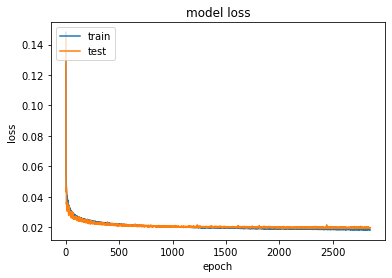

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('training_curves.png')
plt.show()

# Testing

In [20]:
y_predict = model.predict(x_test, batch_size=batch_size) 
y_predict_in_val = model.predict(x_val, batch_size=batch_size)
y_predict_in_train = model.predict(x_train, batch_size=batch_size)


Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_1260692 in device /job:localhost/replica:0/tas

Revert the Representation from normalize to lat-long coordinates

In [21]:
y_predict = scaler_y.inverse_transform(y_predict)
y_predict_in_train = scaler_y.inverse_transform(y_predict_in_train)
y_predict_in_val = scaler_y.inverse_transform(y_predict_in_val)
y_train = scaler_y.inverse_transform(y_train)
y_val = scaler_y.inverse_transform(y_val)
y_test = scaler_y.inverse_transform(y_test)

Calculate Haversine Error

In [22]:
print("Train set mean error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_train, y_train,'mean')))
print("Train set median error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_train, y_train,'median')))
print("Train set75th perc error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_train, y_train,'percentile',75)))
print("Val set mean error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_val, y_val,'mean')))
print("Val set median error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_val, y_val,'median')))
print("Val set 75th perc.  error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_val, y_val,'percentile',75)))
print("Test set mean error: {:.2f}".format(my_custom_haversine_error_stats(y_predict, y_test,'mean')))
print("Test set median error: {:.2f}".format(my_custom_haversine_error_stats(y_predict, y_test,'median')))
print("Test set  75th perc. error: {:.2f}".format(my_custom_haversine_error_stats(y_predict, y_test,'percentile',75)))


Train set mean error: 163.43
Train set median error: 60.75
Train set75th perc error: 193.06
Val set mean error: 206.89
Val set median error: 73.87
Val set 75th perc.  error: 263.17
Test set mean error: 206.16
Test set median error: 71.97
Test set  75th perc. error: 252.38


In [23]:
test_error_list = calculate_pairwise_error_list(y_predict,y_test)
p.DataFrame(test_error_list).to_csv(trial_name+".csv")
print("Experiment completed!!!")

Experiment completed!!!


In [24]:
# keras library import  for Saving and loading model and weights

from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open(trial_name+".json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights(trial_name+".h5")